In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from collections import Counter
import torchvision
import torch.nn.functional as F
from tqdm import tqdm
import random
from torchsummary import summary

# Check if cuda is available
print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
print(torch.cuda.is_available())

pd.set_option('display.max_columns', None)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


torch.autograd.set_detect_anomaly(True)

#U-Net referenced from code： https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py
class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList([
            self.conv_block(3, 64),
            self.conv_block(64, 128),
            self.conv_block(128, 256),
            self.conv_block(256, 512)
        ])
        self.decoder = nn.ModuleList([
            self.up_conv_block(512, 256),
            self.up_conv_block(512, 128),
            self.up_conv_block(256, 64),
            nn.Conv2d(128, n_classes, kernel_size=1)
        ])

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        encoder_out = []
        for block in self.encoder:
            x = block(x)
            encoder_out.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        for i, block in enumerate(self.decoder):
            x = block(x)
            if i < len(encoder_out) - 1:
                x = F.interpolate(x, size=encoder_out[-(i+2)].shape[2:])
                x = torch.cat((x, encoder_out[-(i+2)]), dim=1)

        return x



1
NVIDIA GeForce RTX 2070
12.1
True


In [10]:
# summary
model = UNet(n_classes=17).to('cuda')
summary(model, input_size=(3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
              ReLU-6        [-1, 128, 128, 128]               0
            Conv2d-7        [-1, 128, 128, 128]         147,584
              ReLU-8        [-1, 128, 128, 128]               0
            Conv2d-9          [-1, 256, 64, 64]         295,168
             ReLU-10          [-1, 256, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         590,080
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 512, 32, 32]       1,180,160
             ReLU-14          [-1, 512,

In [11]:
# Data path and load CSV filtrain.csve
train_csv_path = r'c:\Users\89304\OneDrive\桌面\61541v001\train.csv'
val_csv_path = r'c:\Users\89304\OneDrive\桌面\61541v001\val.csv'
test_csv_path = r'c:\Users\89304\OneDrive\桌面\61541v001\test.csv'

train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Randomly sample 30% of the data
train_sampled_df = train_df.sample(frac=0.3, random_state=42)
val_sampled_df = val_df.sample(frac=0.3, random_state=42)
test_sampled_df = test_df.sample(frac=0.3, random_state=42)

# path
base_path = r'C:\Users\89304\OneDrive\桌面\61541v001\data\WildScenes\WildScenes2d'

# path_list
image_paths = []
indexLabel_paths = []
label_paths = []

# collect all image paths
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('.png'):
            new_path = os.path.join(root, file)
            if root.endswith('image'):
                image_paths.append(new_path)
            elif root.endswith('indexLabel'):
                indexLabel_paths.append(new_path)
            elif root.endswith('label'):
                label_paths.append(new_path)

# matching image and label paths
def get_file_paths(file_id, paths):
    for path in paths:
        if file_id in path:
            return path
    return None

# add image path and label path columns
train_sampled_df['image_path'] = train_sampled_df['im_path'].apply(lambda x: get_file_paths(x, image_paths))
train_sampled_df['indexLabel_path'] = train_sampled_df['label_path'].apply(lambda x: get_file_paths(x, indexLabel_paths))

val_sampled_df['image_path'] = val_sampled_df['im_path'].apply(lambda x: get_file_paths(x, image_paths))
val_sampled_df['indexLabel_path'] = val_sampled_df['label_path'].apply(lambda x: get_file_paths(x, indexLabel_paths))

test_sampled_df['image_path'] = test_sampled_df['im_path'].apply(lambda x: get_file_paths(x, image_paths))
test_sampled_df['indexLabel_path'] = test_sampled_df['label_path'].apply(lambda x: get_file_paths(x, indexLabel_paths))

# Convert data to list and sort
train_images = train_sampled_df['im_path'].tolist()
train_labels = train_sampled_df['label_path'].tolist()
val_images = val_sampled_df['im_path'].tolist()
val_labels = val_sampled_df['label_path'].tolist()
test_images = test_sampled_df['im_path'].tolist()
test_labels = test_sampled_df['label_path'].tolist()

train_images.sort()
train_labels.sort()
val_images.sort()
val_labels.sort()
test_images.sort()
test_labels.sort()

image_paths.sort()
indexLabel_paths.sort()

# base path
base_path = r'C:\Users\89304\OneDrive\桌面\61541v001\data\WildScenes'

# create new paths
train_images = [os.path.join(base_path, path).replace('/', '\\') for path in train_images]
train_labels = [os.path.join(base_path, path).replace('/', '\\') for path in train_labels]
val_images = [os.path.join(base_path, path).replace('/', '\\') for path in val_images]
val_labels = [os.path.join(base_path, path).replace('/', '\\') for path in val_labels]
test_images = [os.path.join(base_path, path).replace('/', '\\') for path in test_images]
test_labels = [os.path.join(base_path, path).replace('/', '\\') for path in test_labels]


In [12]:
len(train_images), len(train_labels), len(val_images), len(val_labels), len(test_images), len(test_labels)

(1815, 1815, 85, 85, 640, 640)

In [13]:
def plot_pixel_dist(paths):
    pixel_values = []
    for path in paths:
        try:
            with Image.open(path) as img:
                img_array = np.array(img)
                pixel_values.extend(img_array.flatten())
        except Exception as e:
            print(f"Warning: Failed to read {path} with error: {e}")
    plt.hist(pixel_values, bins=50, color='c', alpha=0.7)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Pixel Intensity Distribution')
    plt.show()

In [14]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, indexLabel_paths, transform=None):
        self.imgs = image_paths
        self.masks = indexLabel_paths
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # Convert mask to grayscale
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            mask = (mask * 255).long()

        mask = mask.squeeze(0)
        
        # Ensure values in mask are within [0, n_classes-1] range
        mask = torch.clamp(mask, min=0, max=16)

        return image, mask

# calculate ious
def calculate_iou(pred, target, n_classes):
    pred = pred.view(-1)
    target = target.view(-1)
    ious = []
    for cls in range(n_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / max(union, 1))
    return np.array(ious)

dataset = CustomImageDataset(train_images, train_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=6, shuffle=True)
val_dataset = CustomImageDataset(val_images, val_labels, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=True)
test_dataset = CustomImageDataset(test_images, test_labels, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=True)



In [15]:
# train and evaluate
def train_and_evaluate(n_classes, num_epochs=25, batch_size=6, learning_rate=1e-3):
    model = UNet(n_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_ious = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(dataloader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        iou_list = []
        with torch.no_grad():
            for images, masks in val_dataloader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                ious = calculate_iou(preds, masks, n_classes)
                iou_list.append(ious)
        
        val_loss = val_loss / len(val_dataloader.dataset)
        val_losses.append(val_loss)
        
        iou_list = np.array(iou_list)
        mean_iou = np.nanmean(iou_list, axis=0)
        val_ious.append(mean_iou)

        with open('output.txt', 'a') as f:
            f.write(f'Epoch {epoch+1}/{num_epochs} Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f} IoU for each class: {mean_iou}\n')
    
    model.eval()
    with torch.no_grad():
        iou_list_val = []
        iou_list_test = []

        for images, masks in val_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            ious = calculate_iou(preds, masks, n_classes)
            iou_list_val.append(ious)

        
        test_images_list = []
        test_masks_list = []
        test_preds_list = []

        for images, masks in test_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            ious = calculate_iou(preds, masks, n_classes)
            iou_list_test.append(ious)

            test_images_list.extend(images.cpu())
            test_masks_list.extend(masks.cpu())
            test_preds_list.extend(preds.cpu())

    
        selected_indices = random.sample(range(len(test_images_list)), 4)
        for idx in selected_indices:
            images = test_images_list[idx].unsqueeze(0)
            masks = test_masks_list[idx].unsqueeze(0)
            preds = test_preds_list[idx].unsqueeze(0)

            # plot images
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 3, 1)
            plt.title('Input Image')
            plt.imshow(images[0].permute(1, 2, 0).numpy())
            plt.subplot(1, 3, 2)
            plt.title('Ground Truth')
            plt.imshow(masks[0].numpy(), cmap='gray')
            plt.subplot(1, 3, 3)
            plt.title('Prediction')
            plt.imshow(preds[0].numpy(), cmap='gray')
            plt.show()

        iou_list_val = np.array(iou_list_val)
        iou_list_test = np.array(iou_list_test)
        print(f'Validation IoU for each class: {np.nanmean(iou_list_val, axis=0)}')
        print(f'Test IoU for each class: {np.nanmean(iou_list_test, axis=0)}')
        #save as txt
        with open('output.txt', 'a') as f:
            f.write(f'Validation IoU for each class: {np.nanmean(iou_list_val, axis=0)}\n')
            f.write(f'Test IoU for each class: {np.nanmean(iou_list_test, axis=0)}\n')

    # plot loss and iou
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot ious
    plt.figure(figsize=(10, 5))
    for i in range(n_classes):
        plt.plot(range(1, num_epochs + 1), [iou[i] for iou in val_ious], label=f'Class {i} IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.show()


Epoch 1/100: 100%|██████████| 303/303 [03:39<00:00,  1.38batch/s]
C:\Users\89304\AppData\Local\Temp\ipykernel_5396\1862568663.py:43: RuntimeWarning: Mean of empty slice
  mean_iou = np.nanmean(iou_list, axis=0)
Epoch 100/100: 100%|██████████| 303/303 [03:42<00:00,  1.36batch/s]


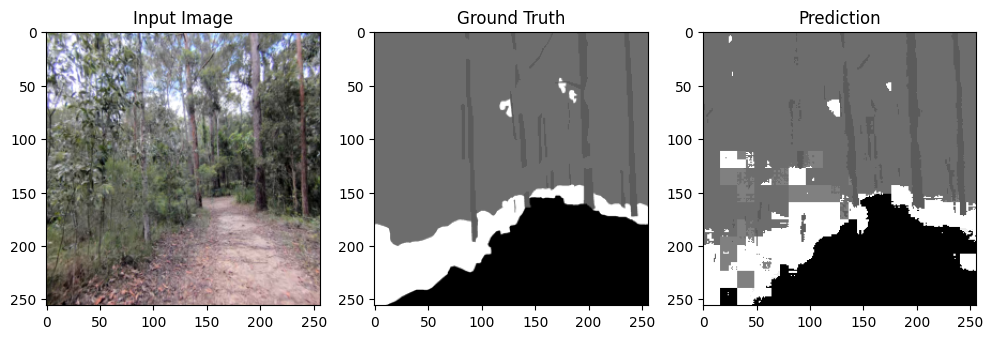

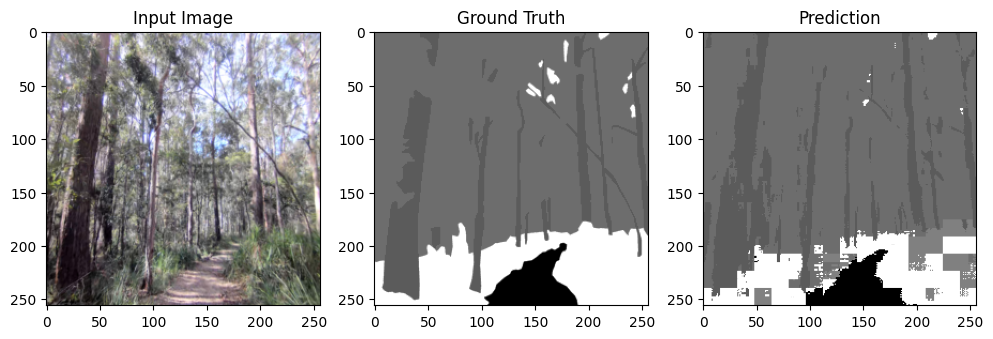

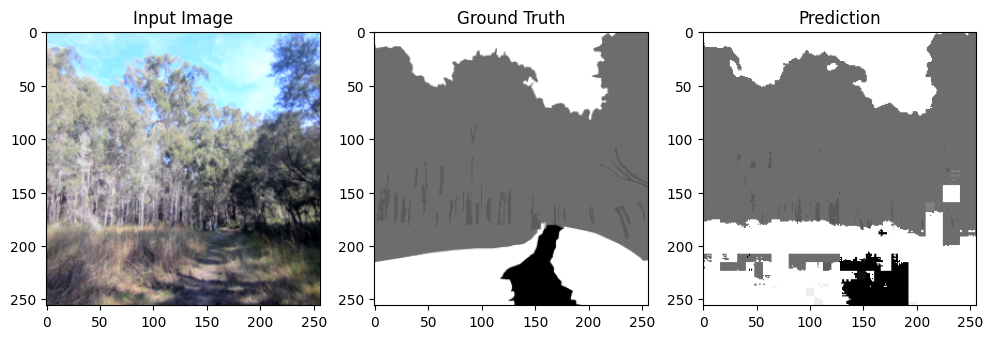

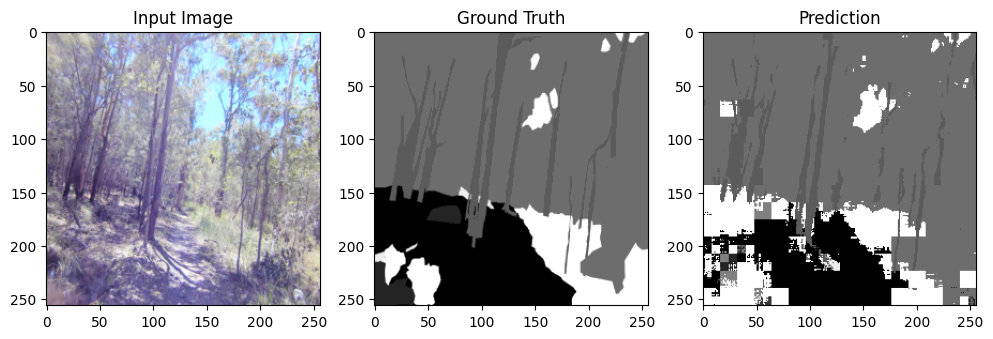

Validation IoU for each class: [           nan            nan 5.68709944e-01 7.48455332e-03
 4.84904885e-04 1.28786227e-03 2.28235516e-03 4.62717339e-01
 8.03834651e-01 2.01344775e-02 3.82763954e-04 6.53411042e-04
 2.61068419e-04 0.00000000e+00 3.00337314e-04 4.17791964e-02
 6.05427918e-01]
Test IoU for each class: [           nan 0.00000000e+00 6.47390158e-01 6.26574416e-03
 1.87742787e-02 1.77283804e-03 2.12389222e-03 4.70034044e-01
 8.04886937e-01 5.90724759e-02 3.87367532e-04 6.02897621e-02
 4.87881236e-03 2.59449114e-04 3.01441683e-03 5.62971065e-02
 5.89829836e-01]


C:\Users\89304\AppData\Local\Temp\ipykernel_5396\1862568663.py:99: RuntimeWarning: Mean of empty slice
  print(f'Validation IoU for each class: {np.nanmean(iou_list_val, axis=0)}')
C:\Users\89304\AppData\Local\Temp\ipykernel_5396\1862568663.py:100: RuntimeWarning: Mean of empty slice
  print(f'Test IoU for each class: {np.nanmean(iou_list_test, axis=0)}')
C:\Users\89304\AppData\Local\Temp\ipykernel_5396\1862568663.py:103: RuntimeWarning: Mean of empty slice
  f.write(f'Validation IoU for each class: {np.nanmean(iou_list_val, axis=0)}\n')
C:\Users\89304\AppData\Local\Temp\ipykernel_5396\1862568663.py:104: RuntimeWarning: Mean of empty slice
  f.write(f'Test IoU for each class: {np.nanmean(iou_list_test, axis=0)}\n')


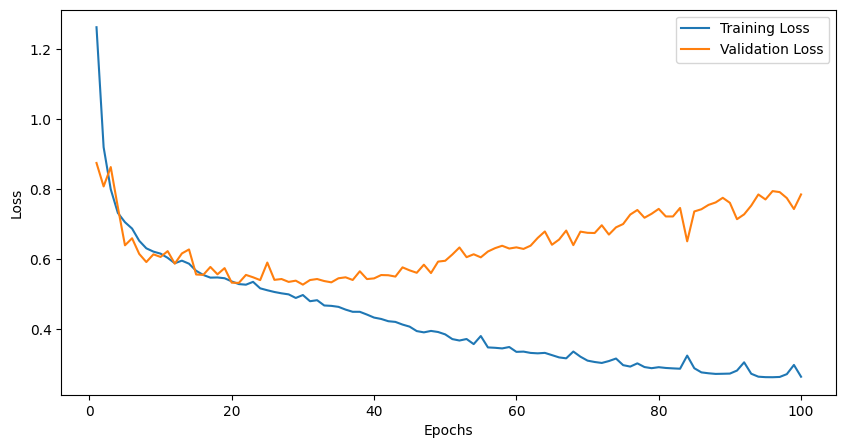

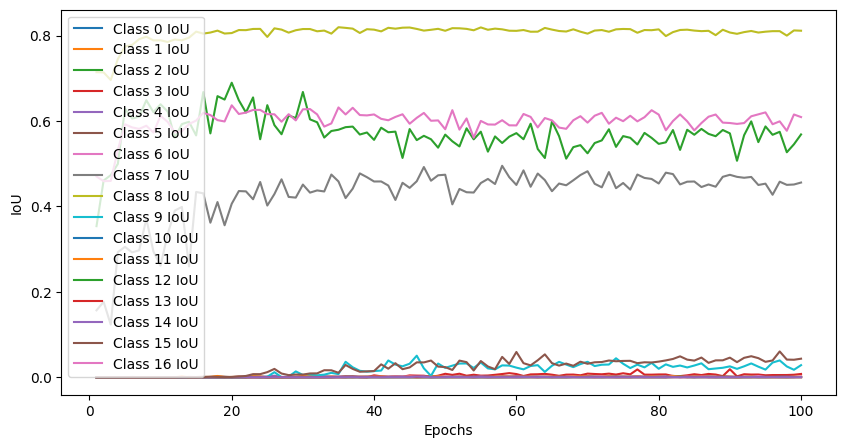

In [16]:
train_and_evaluate(n_classes=17, num_epochs=100, batch_size=6, learning_rate=1e-3)